In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SIZE = (224, 224)
BATCH_SIZE = 64

data_dir = 'COVID-19_Radiography_Dataset'

datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.3,
)

train_generator = datagen.flow_from_directory(
    data_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_generator = datagen.flow_from_directory(
    data_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)


2025-04-21 08:53:26.630028: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745225606.653697     701 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745225606.660409     701 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Found 29632 images belonging to 4 classes.
Found 12698 images belonging to 4 classes.


In [2]:
print("Class indices:", train_generator.class_indices)


Class indices: {'COVID': 0, 'Lung_Opacity': 1, 'Normal': 2, 'Viral Pneumonia': 3}


In [3]:
from tensorflow.keras.applications import MobileNetV2

base_model = MobileNetV2(input_shape=IMG_SIZE + (3,), include_top=False, weights='imagenet')
base_model.trainable = False  


I0000 00:00:1745225622.690739     701 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1745225622.691457     701 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


In [4]:
from tensorflow.keras import layers, models

num_classes = train_generator.num_classes

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(1024, activation='relu'),
    layers.Dense(512, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])


In [5]:
model.summary()
total_params = model.count_params()
print("Total parameters:", total_params)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1024)                │       1,311,744 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 4)                   │           2,052 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,096,580 (15.63 MB)

 Trainable params: 1,838,596 (7.01 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

Total parameters: 4096580


In [6]:
base_model.trainable = False


In [7]:



from tensorflow.keras.optimizers import Adam
import time

def train_model(strategy_name, base_model, train_generator, val_generator, unfreeze_layers=0):
    # Freeze all layers initially
    base_model.trainable = False

    # Unfreeze the last 'unfreeze_layers' layers if specified
    if unfreeze_layers > 0:
        base_model.trainable = True
        for layer in base_model.layers[:-unfreeze_layers]:
            layer.trainable = False

    # Build the model
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(1024, activation='relu'),
        layers.Dense(512, activation='relu'),
        layers.Dense(train_generator.num_classes, activation='softmax')
    ])

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    # Train the model
    start_time = time.time()
    history = model.fit(train_generator,
                        epochs=20,
                        validation_data=val_generator,
                        batch_size=64)
    end_time = time.time()
    training_time = end_time - start_time

    return model, history, training_time

# Strategy A: Only fully connected layers
model_a, history_a, time_a = train_model("Strategy A", base_model, train_generator, val_generator, unfreeze_layers=0)

# Strategy B: Last one convolutional layer + fully connected layers
model_b, history_b, time_b = train_model("Strategy B", base_model, train_generator, val_generator, unfreeze_layers=20)

# Strategy C: Last two convolutional layers + fully connected layers
model_c, history_c, time_c = train_model("Strategy C", base_model, train_generator, val_generator, unfreeze_layers=40)


Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1745225633.601084     749 service.cc:148] XLA service 0x7eb008002150 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1745225633.601124     749 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1745225633.601128     749 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1745225634.442100     749 cuda_dnn.cc:529] Loaded cuDNN version 90300


  2/463 ━━━━━━━━━━━━━━━━━━━━ 27s 59ms/step - accuracy: 0.3320 - loss: 1.8992   

I0000 00:00:1745225639.501624     749 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


463/463 ━━━━━━━━━━━━━━━━━━━━ 184s 367ms/step - accuracy: 0.6609 - loss: 0.9239 - val_accuracy: 0.8501 - val_loss: 0.4032
Epoch 2/20
463/463 ━━━━━━━━━━━━━━━━━━━━ 160s 341ms/step - accuracy: 0.7634 - loss: 0.5938 - val_accuracy: 0.8426 - val_loss: 0.4254
Epoch 3/20
463/463 ━━━━━━━━━━━━━━━━━━━━ 162s 347ms/step - accuracy: 0.7767 - loss: 0.5655 - val_accuracy: 0.8664 - val_loss: 0.3716
Epoch 4/20
463/463 ━━━━━━━━━━━━━━━━━━━━ 162s 348ms/step - accuracy: 0.7903 - loss: 0.5269 - val_accuracy: 0.8446 - val_loss: 0.4128
Epoch 5/20
463/463 ━━━━━━━━━━━━━━━━━━━━ 165s 353ms/step - accuracy: 0.7973 - loss: 0.5145 - val_accuracy: 0.8478 - val_loss: 0.4196
Epoch 6/20
463/463 ━━━━━━━━━━━━━━━━━━━━ 162s 347ms/step - accuracy: 0.7999 - loss: 0.4987 - val_accuracy: 0.8756 - val_loss: 0.3642
Epoch 7/20
463/463 ━━━━━━━━━━━━━━━━━━━━ 164s 352ms/step - accuracy: 0.8091 - loss: 0.4831 - val_accuracy: 0.8651 - val_loss: 0.4420
Epoch 8/20
463/463 ━━━━━━━━━━━━━━━━━━━━ 164s 351ms/step - accuracy: 0.8139 - loss: 0.47

E0000 00:00:1745228938.698081     750 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1745228938.838557     750 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


463/463 ━━━━━━━━━━━━━━━━━━━━ 185s 359ms/step - accuracy: 0.7011 - loss: 0.7595 - val_accuracy: 0.5483 - val_loss: 3.7037
Epoch 2/20
463/463 ━━━━━━━━━━━━━━━━━━━━ 162s 347ms/step - accuracy: 0.7986 - loss: 0.5268 - val_accuracy: 0.8167 - val_loss: 0.8607
Epoch 3/20
463/463 ━━━━━━━━━━━━━━━━━━━━ 161s 344ms/step - accuracy: 0.8158 - loss: 0.4763 - val_accuracy: 0.6427 - val_loss: 2.1487
Epoch 4/20
463/463 ━━━━━━━━━━━━━━━━━━━━ 161s 344ms/step - accuracy: 0.8279 - loss: 0.4480 - val_accuracy: 0.7742 - val_loss: 1.0764
Epoch 5/20
463/463 ━━━━━━━━━━━━━━━━━━━━ 166s 355ms/step - accuracy: 0.8375 - loss: 0.4256 - val_accuracy: 0.9075 - val_loss: 0.3780
Epoch 6/20
463/463 ━━━━━━━━━━━━━━━━━━━━ 165s 353ms/step - accuracy: 0.8453 - loss: 0.4029 - val_accuracy: 0.8969 - val_loss: 0.3960
Epoch 7/20
463/463 ━━━━━━━━━━━━━━━━━━━━ 171s 366ms/step - accuracy: 0.8502 - loss: 0.3855 - val_accuracy: 0.8779 - val_loss: 0.5162
Epoch 8/20
463/463 ━━━━━━━━━━━━━━━━━━━━ 163s 350ms/step - accuracy: 0.8585 - loss: 0.36

199/199 ━━━━━━━━━━━━━━━━━━━━ 56s 279ms/step

Classification Report for Strategy A:

                 precision    recall  f1-score   support

          COVID       0.44      0.19      0.27      2169
   Lung_Opacity       0.87      0.82      0.84      3607
         Normal       0.68      0.93      0.78      6115
Viral Pneumonia       0.00      0.00      0.00       807

       accuracy                           0.71     12698
      macro avg       0.50      0.48      0.47     12698
   weighted avg       0.65      0.71      0.66     12698



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


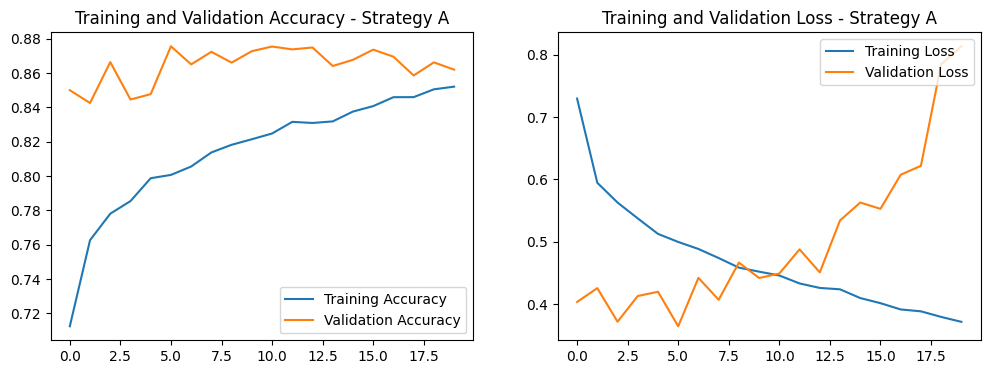

199/199 ━━━━━━━━━━━━━━━━━━━━ 60s 286ms/step

Classification Report for Strategy B:

                 precision    recall  f1-score   support

          COVID       0.89      0.96      0.92      2169
   Lung_Opacity       0.89      0.87      0.88      3607
         Normal       0.93      0.92      0.92      6115
Viral Pneumonia       0.93      0.86      0.89       807

       accuracy                           0.91     12698
      macro avg       0.91      0.90      0.90     12698
   weighted avg       0.91      0.91      0.91     12698



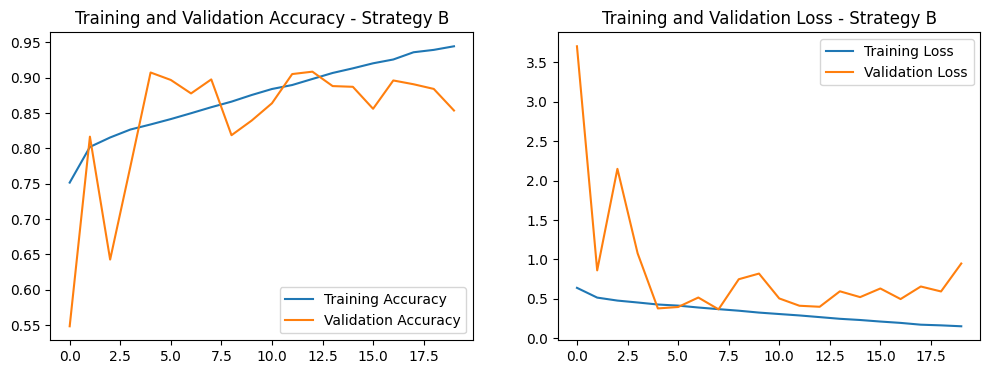

199/199 ━━━━━━━━━━━━━━━━━━━━ 61s 290ms/step

Classification Report for Strategy C:

                 precision    recall  f1-score   support

          COVID       0.92      0.95      0.93      2169
   Lung_Opacity       0.92      0.84      0.88      3607
         Normal       0.90      0.95      0.93      6115
Viral Pneumonia       0.97      0.84      0.90       807

       accuracy                           0.91     12698
      macro avg       0.93      0.89      0.91     12698
   weighted avg       0.91      0.91      0.91     12698



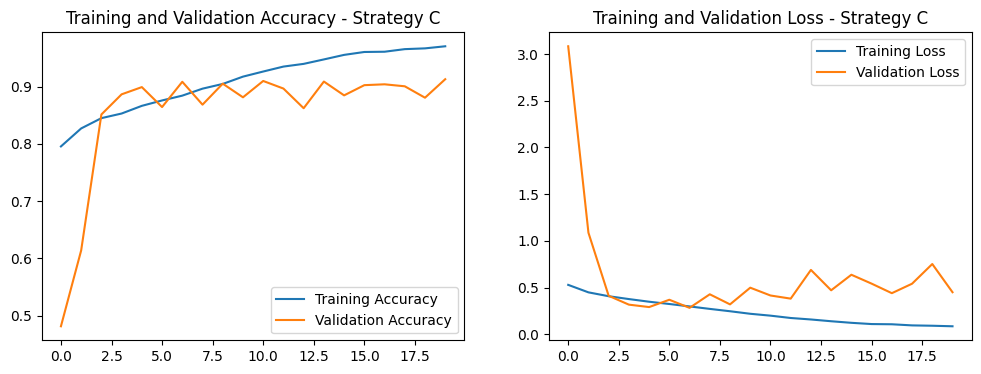

In [14]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

def evaluate_model(model, val_generator, history, strategy_name):
    # Predict on validation data
    val_preds = model.predict(val_generator)
    y_pred = np.argmax(val_preds, axis=1)
    y_true = val_generator.classes

    # Classification report
    print(f"\nClassification Report for {strategy_name}:\n")
    print(classification_report(y_true, y_pred, target_names=val_generator.class_indices.keys()))

    # Plot accuracy and loss curves
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(20)

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title(f'Training and Validation Accuracy - {strategy_name}')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title(f'Training and Validation Loss - {strategy_name}')
    plt.show()

# Evaluate Strategy A
evaluate_model(model_a, val_generator, history_a, "Strategy A")
evaluate_model(model_b, val_generator, history_b, "Strategy B")
evaluate_model(model_c, val_generator, history_c, "Strategy C")
